# 코드 설명 요약
* 영상 처리 및 자세 추정: OpenCV와 MediaPipe를 사용하여 각 프레임에서 힙과 발목 좌표를 추출, 몸의 중앙과 발의 수평 거리를 계산합니다.
* 스텝 계산: 프레임별 거리 변화를 기반으로 스텝 수를 계산하고, 단순 로직으로 인사이드/아웃사이드 스텝 수를 도출합니다.
* 후보 프레임 추출: 각 프레임마다 인사이드 및 아웃사이드 스텝 확률을 산출하고, 확률 기준 내림차순 정렬 후 상위 3개 프레임을 선택하여 파일로 저장하고 시각화합니다.
* 피드백 제공: 전체 스텝 수에 따른 인사이드/아웃사이드 비율에 기반해 개선점을 피드백합니다.

I0000 00:00:1743141757.275716 3058400 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4
W0000 00:00:1743141757.355672 3101794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743141757.367011 3101800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


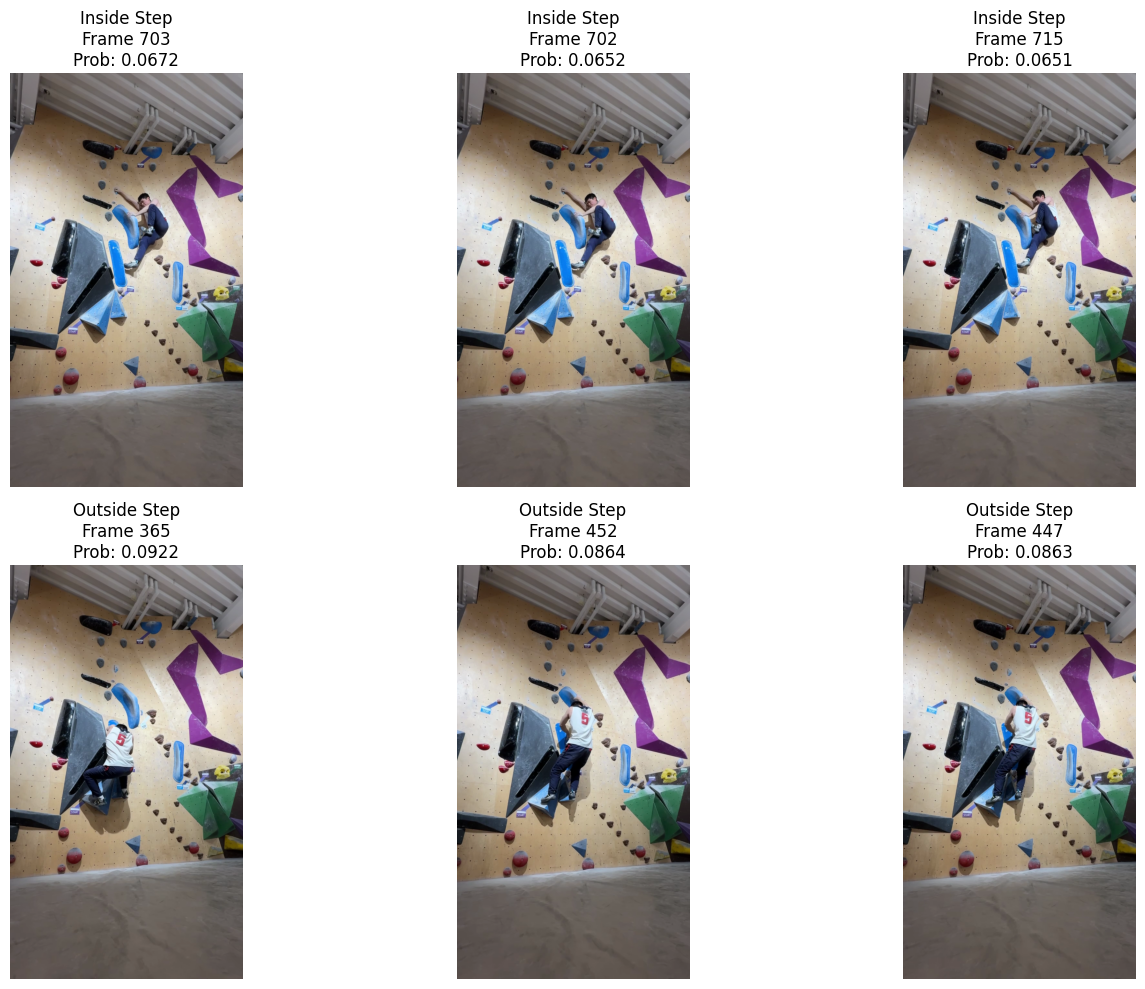

인사이드 스텝 수: 1
아웃사이드 스텝 수: 2
피드백: 아웃사이드 스텝이 많습니다. 클라이밍 시 발을 좀 더 가까이 유지해보세요.


In [6]:
import cv2  # OpenCV 라이브러리를 불러와 영상 입출력 및 처리에 사용합니다.
import mediapipe as mp  # MediaPipe 라이브러리를 불러와 자세 추정에 사용합니다.
import numpy as np  # 수치 계산을 위해 numpy를 불러옵니다.
import matplotlib.pyplot as plt  # matplotlib를 불러와 이미지 출력에 사용합니다.

# 프레임별 거리 변화량을 이용해 스텝 수를 계산하는 함수입니다.
def count_steps(distance_list, threshold=0.02):
    steps = 0  # 스텝 횟수를 저장할 변수를 0으로 초기화합니다.
    for i in range(1, len(distance_list)):  # 각 프레임에 대해 반복합니다.
        # 이전 프레임과의 거리 변화가 threshold보다 크면 스텝으로 간주합니다.
        if abs(distance_list[i] - distance_list[i-1]) > threshold:
            steps += 1  # 스텝 횟수를 1 증가시킵니다.
    return steps  # 계산된 스텝 수를 반환합니다.

# 인사이드/아웃사이드 스텝 수에 기반해 피드백을 제공하는 함수입니다.
def provide_feedback(inside_steps, outside_steps):
    total_steps = inside_steps + outside_steps  # 총 스텝 수를 계산합니다.
    feedback = ""  # 피드백 메시지를 저장할 변수를 초기화합니다.
    if total_steps == 0:  # 스텝 수가 0이면, 자세 인식이 원활하지 않다고 판단합니다.
        feedback = "자세 인식이 원활하지 않습니다. 영상의 해상도나 촬영 환경을 확인해주세요."
    else:
        # 인사이드와 아웃사이드 스텝 비율을 계산합니다.
        inside_ratio = inside_steps / total_steps
        outside_ratio = outside_steps / total_steps
        # 비율에 따라 피드백 메시지를 설정합니다.
        if inside_ratio > 0.6:
            feedback = "인사이드 스텝이 많습니다. 외발 중심의 동작을 시도하여 균형을 맞춰보세요."
        elif outside_ratio > 0.6:
            feedback = "아웃사이드 스텝이 많습니다. 클라이밍 시 발을 좀 더 가까이 유지해보세요."
        else:
            feedback = "발의 스텝이 균형을 이루고 있습니다. 이 상태를 유지하면서 점진적으로 난이도를 높여보세요."
    return feedback  # 최종 피드백 메시지를 반환합니다.

# 영상 분석 및 후보 프레임 추출 함수입니다.
def analyze_and_extract(video_path):
    # MediaPipe의 Pose 모듈을 초기화합니다.
    mp_pose = mp.solutions.pose  # MediaPipe의 pose 모듈을 가져옵니다.
    pose = mp_pose.Pose()  # 자세 추정을 위한 Pose 객체를 생성합니다.
    
    # OpenCV를 사용하여 입력 영상을 엽니다.
    cap = cv2.VideoCapture(video_path)  # 지정된 경로의 영상을 불러옵니다.
    
    # 스텝 수 계산을 위한 왼쪽/오른쪽 발의 중간선과의 거리 변화를 저장할 리스트를 초기화합니다.
    left_foot_distances = []  # 왼쪽 발의 거리를 저장할 리스트
    right_foot_distances = []  # 오른쪽 발의 거리를 저장할 리스트
    
    # 인사이드 스텝과 아웃사이드 스텝 후보 프레임(확률, 프레임, 프레임 인덱스)을 저장할 리스트입니다.
    inside_frames = []  # 인사이드 스텝 후보 프레임 리스트
    outside_frames = []  # 아웃사이드 스텝 후보 프레임 리스트
    
    frame_index = 0  # 현재 프레임 번호를 저장할 변수를 초기화합니다.
    
    # 영상의 모든 프레임을 처리합니다.
    while cap.isOpened():
        ret, frame = cap.read()  # 한 프레임을 읽어옵니다.
        if not ret:  # 프레임을 더 이상 읽을 수 없으면 반복문을 종료합니다.
            break
        
        # MediaPipe는 RGB 이미지를 필요로 하므로 BGR 형식의 프레임을 RGB로 변환합니다.
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # MediaPipe를 사용하여 자세 랜드마크를 추정합니다.
        results = pose.process(image_rgb)
        
        # 자세 랜드마크가 검출된 경우에만 처리합니다.
        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark  # 검출된 랜드마크 정보를 가져옵니다.
            
            # 왼쪽 힙과 오른쪽 힙의 x 좌표를 추출해 몸의 중앙(중간선)을 계산합니다.
            left_hip_x = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x
            right_hip_x = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x
            mid_x = (left_hip_x + right_hip_x) / 2  # 중간선의 x 좌표
            
            # 왼쪽 발목과 오른쪽 발목의 x 좌표를 추출합니다.
            left_ankle_x = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x
            right_ankle_x = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x
            
            # 각 발목과 중간선 사이의 수평 거리를 절대값으로 계산합니다.
            left_distance = abs(left_ankle_x - mid_x)
            right_distance = abs(right_ankle_x - mid_x)
            
            # 스텝 수 계산을 위해 프레임별 거리를 리스트에 저장합니다.
            left_foot_distances.append(left_distance)
            right_foot_distances.append(right_distance)
            
            # 인사이드 스텝일 가능성을 계산합니다.
            # (왼쪽 발이 중간선에 더 가까우면 right_distance가 더 크므로, 그 차이를 인사이드 확률로 사용)
            inside_prob = (right_distance - left_distance) if (right_distance - left_distance) > 0 else 0
            
            # 아웃사이드 스텝일 가능성을 계산합니다.
            # (오른쪽 발이 중간선에 더 가까우면 left_distance가 더 크므로, 그 차이를 아웃사이드 확률로 사용)
            outside_prob = (left_distance - right_distance) if (left_distance - right_distance) > 0 else 0
            
            # 인사이드 스텝 후보 프레임일 경우, 해당 프레임 정보를 저장합니다.
            if inside_prob > 0:
                inside_frames.append((inside_prob, frame.copy(), frame_index))
            # 아웃사이드 스텝 후보 프레임일 경우, 해당 프레임 정보를 저장합니다.
            if outside_prob > 0:
                outside_frames.append((outside_prob, frame.copy(), frame_index))
        
        frame_index += 1  # 다음 프레임으로 인덱스를 증가시킵니다.
    
    cap.release()  # 영상 처리가 완료되면 캡처 객체를 해제합니다.
    
    # 저장된 거리 정보를 기반으로 각각의 스텝 수를 계산합니다.
    left_steps = count_steps(left_foot_distances, threshold=0.02)
    right_steps = count_steps(right_foot_distances, threshold=0.02)
    
    # 단순 예시로, 인사이드와 아웃사이드 스텝 수를 전체 스텝 수를 반으로 나눈 값으로 계산합니다.
    inside_steps = (left_steps + right_steps) // 2
    outside_steps = (left_steps + right_steps) - inside_steps
    
    # 계산된 스텝 수를 바탕으로 피드백 메시지를 생성합니다.
    feedback = provide_feedback(inside_steps, outside_steps)
    
    # 인사이드 및 아웃사이드 후보 프레임을 확률 내림차순으로 정렬합니다.
    inside_frames_sorted = sorted(inside_frames, key=lambda x: x[0], reverse=True)
    outside_frames_sorted = sorted(outside_frames, key=lambda x: x[0], reverse=True)
    
    # 각 분류별 상위 3개 프레임을 선택합니다.
    top_inside = inside_frames_sorted[:3]
    top_outside = outside_frames_sorted[:3]
    
    # # 선택된 인사이드 스텝 프레임을 파일로 저장하고 저장 결과를 출력합니다.
    # for i, (prob, frame, idx) in enumerate(top_inside):
    #     filename = f"inside_step_top{i+1}_frame{idx}.jpg"  # 파일명 생성
    #     cv2.imwrite(filename, frame)  # 이미지 파일로 저장
    #     print(f"Saved {filename} with inside step probability: {prob:.4f}")
    
    # # 선택된 아웃사이드 스텝 프레임을 파일로 저장하고 저장 결과를 출력합니다.
    # for i, (prob, frame, idx) in enumerate(top_outside):
    #     filename = f"outside_step_top{i+1}_frame{idx}.jpg"  # 파일명 생성
    #     cv2.imwrite(filename, frame)  # 이미지 파일로 저장
    #     print(f"Saved {filename} with outside step probability: {prob:.4f}")
    
    # matplotlib를 사용하여 상위 프레임들을 화면에 출력합니다.
    # 2행 3열의 그리드를 생성합니다. 첫 번째 행: 인사이드 스텝, 두 번째 행: 아웃사이드 스텝.
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # 인사이드 스텝 상위 이미지들을 첫 번째 행에 출력합니다.
    for j, (prob, frame, idx) in enumerate(top_inside):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR 이미지를 RGB로 변환합니다.
        axs[0, j].imshow(frame_rgb)  # 이미지를 서브플롯에 출력합니다.
        axs[0, j].set_title(f"Inside Step\nFrame {idx}\nProb: {prob:.4f}")  # 제목에 프레임 번호와 확률을 표시합니다.
        axs[0, j].axis("off")  # 축을 숨깁니다.
    
    # 아웃사이드 스텝 상위 이미지들을 두 번째 행에 출력합니다.
    for j, (prob, frame, idx) in enumerate(top_outside):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # 이미지를 RGB로 변환합니다.
        axs[1, j].imshow(frame_rgb)  # 이미지를 서브플롯에 출력합니다.
        axs[1, j].set_title(f"Outside Step\nFrame {idx}\nProb: {prob:.4f}")  # 제목에 프레임 번호와 확률을 표시합니다.
        axs[1, j].axis("off")  # 축을 숨깁니다.
    
    plt.tight_layout()  # 레이아웃을 자동 조정합니다.
    plt.show()  # 최종 이미지를 화면에 출력합니다.
    
    # 계산된 인사이드/아웃사이드 스텝 수와 피드백 메시지를 반환합니다.
    return inside_steps, outside_steps, feedback

# 메인 실행 영역: 스크립트가 직접 실행될 때 아래 코드가 동작합니다.
if __name__ == "__main__":
    video_path = "/Users/laxdin24/Downloads/IMG_5034.MP4"  # 분석할 클라이밍 영상 파일 경로를 지정합니다.
    # 영상 분석 및 후보 프레임 추출 함수를 실행합니다.
    inside_steps, outside_steps, feedback = analyze_and_extract(video_path)
    
    # 분석 결과인 인사이드/아웃사이드 스텝 수와 피드백 메시지를 출력합니다.
    print("인사이드 스텝 수:", inside_steps)
    print("아웃사이드 스텝 수:", outside_steps)
    print("피드백:", feedback)